# Video Classification
The third exercise in the course Neural Networks for Computer Vision.  
UCF101 dataset was used to train CNN classification architecture to classify videos.  
There are two parts to the exercise:  
First, an early fusion video classification architecture is implemented.  
Second, a SlowFast video classifier using a ResNet-50 architecture and PytorchVideo.

Submitted By:

* Tal Goldengoren
* Guy Kabiri

Table of Contents:
* [Imports](#imports)
* [Data Exploration](#data-exp)
* [Part 1 - Early Methods](#part1)
    * [Early Fusion](#early-fusion)
    * [Training](#part1-training)
    * [Results](#part1-results)
        * [ResNet-101](#part1-resnet101)
        * [ResNeXt-50](#part1-resnext50)
        * [ResNet-50](#part1-resnet50)
* [Part 2 - Modern Methods](#part2)
    * [SlowFast](#slowfast)
    * [Training](#part2-training)
    * [Results](#part2-results)
        * [ResNet-50](#part2-resnet50)

# Imports

In [59]:
import numpy as np
import pandas as pd
import torch
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import os

# Data Exploration <span id="data-exp"><span>

The dataset used in this task is [UCF101](https://www.crcv.ucf.edu/data/UCF101.php).  
UCF 101 is a set of action recognition videos from YouTube, with 101 action categories.  
In this exercise, five classes were used:  
Basketball, Rope Climbing, Biking, Diving, Pizza Tossing.

![ezgif com-gif-maker(2)](https://user-images.githubusercontent.com/52006798/146636228-17ab769c-a0cf-4c67-80c5-ced0b64faccd.gif)
![ezgif com-gif-maker(3)](https://user-images.githubusercontent.com/52006798/146636230-3b20aca2-a10f-467b-b064-367e997a2b30.gif)
![ezgif com-gif-maker(5)](https://user-images.githubusercontent.com/52006798/146636293-24618694-cda6-4302-a0ae-471ade8b249a.gif)
![ezgif com-gif-maker(1)](https://user-images.githubusercontent.com/52006798/146636232-b3dcb451-0582-4680-b906-0a4af4ae3f87.gif)
![ezgif com-gif-maker](https://user-images.githubusercontent.com/52006798/146636234-5f107235-393c-4393-afce-67666bcf4b07.gif)


In [46]:
phases = [ 'train', 'valid', 'test' ]
paths = { p: 'data/{}'.format(p) for p in phases }

In [47]:
df = pd.DataFrame(columns=[ 'name', 'class', 'frames', 'phase' ])

In [48]:
for p in phases:
    for cls in os.listdir(paths[p]):     #   iterate over the classes of each phase
        class_path = os.path.join(paths[p], cls)
        videos = [ f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f)) ]
        for vid in videos:
            video_path = os.path.join(class_path, vid)

            cap = cv2.VideoCapture(video_path)
            df = df.append({
                'name': vid,
                'class': cls,
                'frames': int(cap.get(cv2.CAP_PROP_FRAME_COUNT)),
                'phase': p
            }, ignore_index=True)
            cap.release()
            

In [49]:
for p in phases:
    print('Samples in {} set: {}'.format(p, len(df[df['phase']==p])))

Samples in train set: 522
Samples in valid set: 128
Samples in test set: 18


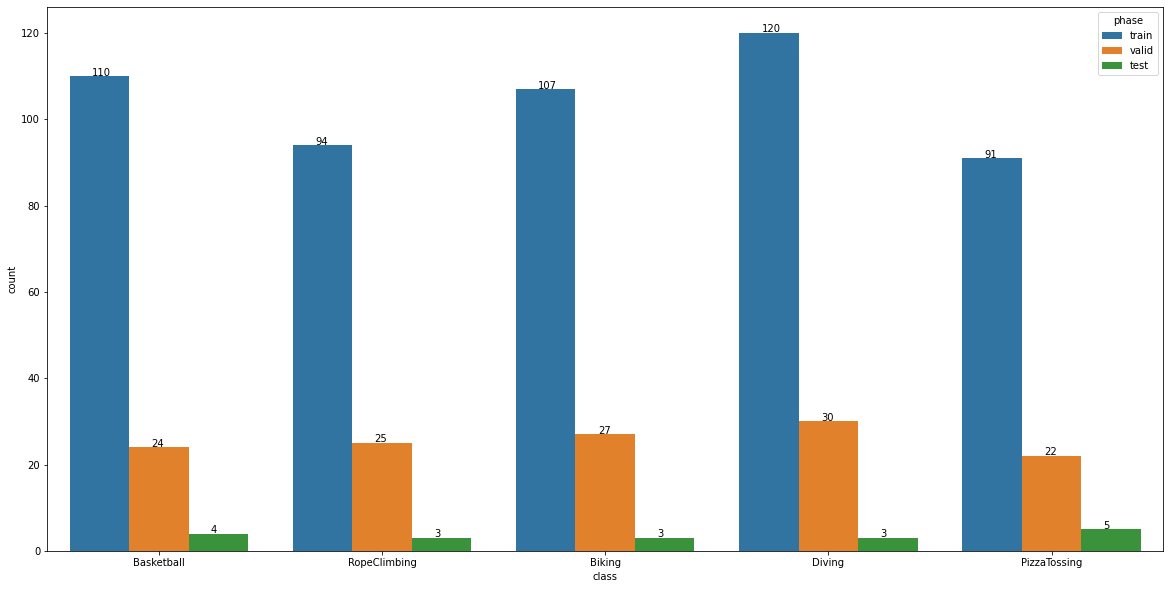

In [124]:
def plot_class_count(df):
    fig = plt.figure(figsize=(20, 10))
    ax = sns.countplot(x='class', hue='phase', data=df)
    for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.1, p.get_height()+0.15))


plot_class_count(df)

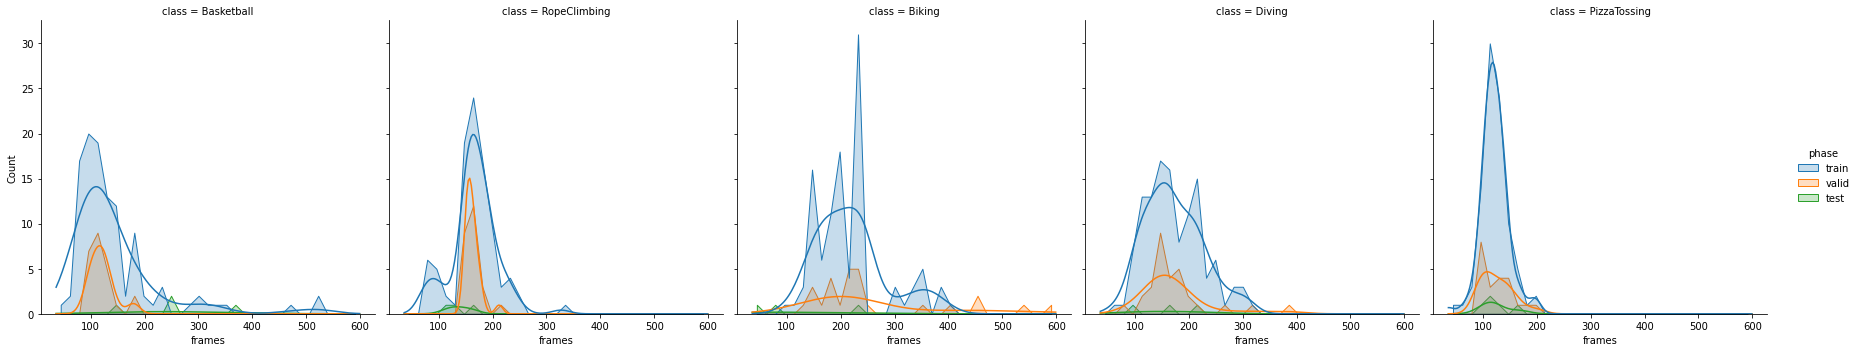

In [134]:
def plot_frames_dist(df):
    # fig = plt.figure(figsize=(50, 5))
    ax = sns.displot(df, x='frames', hue='phase', kde=True, element='poly', col='class', )

plot_frames_dist(df)

# Part 1 - Early methods <span id="part1"><span>
The first part of the exercise includes two early video processing methods, Early Fusion, and Late Fusion.  

Unlike image classification, where a single image has three dimensions, video classification adds a fourth dimension - Time/Frame.  
In order to make a CNN model suitable for video classification, a modification is required.  
Several methods exist for dealing with this issue, including Early Fusion, Late Fusion, Slow Fusion, and Fast Fusion.  
![image](https://user-images.githubusercontent.com/52006798/146635639-db3cd74f-7889-405c-ae82-1e3aaab9c0e8.png)  
Implementing this exercise required either Early Fusion or Late Fusion, and Early Fusion was selected.

## Early Fusion <span id="early-fusion"><span>
In a CNN model, the first convolution layer has an input of three channels, representing the three color channels in the image.  
During video-CNN processing, the first layer handles 3 channels of color simultaneously in each frame.  

How it works:  
Video samples representing batch will be [ B, F, 3, H, W ]. Image CNN architectures, however, utilize 2D CNN blocks.  
Additionally, all of the frames must be analyzed simultaneously. There is a reshape required, so the first convolution layer will be performed on all frames in the architecture.  
Therefore, the new batch size dimensions are [ B, 3F, H, W ].  
It means two things, each batch should be modified at runtime, and the first CNN layer in the architecture should be changed in advance to be in the shape of [3F, H, W].  
Finally, when dealing with pre-trained architecture, the last fully connected layer should be modified as well to the desired number of classes.  

Legend:  
* `B` - batch size
* `F` - number of frames
* `C` - number of channels
* `H` - height
* `W` - width

## Training <span id="part1-training"><span>
In the training process, two methods were used:  
1. Data preprocessing by selecting an advanced subset of frames from each video and training only on these frames.  
The training progress should be extremely fast since the frames were already stored in the storage and only needed to be loaded. However, a small dataset may quickly overfit this method.  
In this method the frames were sampled by a fixed step each time. step = len(total_frames) / len(subset_frames).  
2. Each time, sample a random group of frames. In theory, this would be slower, but it could help prevent overfitting since each time a video is loaded, a different subset of frames is processed by the network.  

Both methods applied transformations to each frame.

## Results <span id="part1-results"><span>

### ResNet-101 <span id="part1-resnet101"><span>

Legend:  
* Green - `laced-sky-39` - Resnet101 w/o dynamic frame dataset
* Orange - `bumbling-vortex-41` - Resnet101 w/ dynamic frame dataset

<img src="https://user-images.githubusercontent.com/52006798/146638883-8737aa8d-7dd5-447b-9571-833d1bbccdf3.png" width="40%"/><img src="https://user-images.githubusercontent.com/52006798/146638884-a4cf7fba-5e15-4d92-973a-f68c93e10fce.png" width="40%"/>

<img src="https://user-images.githubusercontent.com/52006798/146638888-a91ed6cc-a558-4ae7-87e7-fd738ffab8cb.png" width="40%"/><img src="https://user-images.githubusercontent.com/52006798/146638882-c96d9c62-34cd-4ebd-ac5b-440feef6fd8b.png" width="40%"/>

### ResNeXt-50 <span id="part1-resnext50"><span>

Legend:  
* Green - `laced-sky-39` - ResNeXt-50 w/o dynamic frame dataset
* Orange - `bumbling-vortex-41` - ResNeXt-50 w/ dynamic frame dataset

<img src="https://user-images.githubusercontent.com/52006798/146638883-8737aa8d-7dd5-447b-9571-833d1bbccdf3.png" width="40%"/><img src="https://user-images.githubusercontent.com/52006798/146638884-a4cf7fba-5e15-4d92-973a-f68c93e10fce.png" width="40%"/>

<img src="https://user-images.githubusercontent.com/52006798/146638888-a91ed6cc-a558-4ae7-87e7-fd738ffab8cb.png" width="40%"/><img src="https://user-images.githubusercontent.com/52006798/146638882-c96d9c62-34cd-4ebd-ac5b-440feef6fd8b.png" width="40%"/>

### ResNet-50 <span id="part1-resnet50"><span>

Legend:  
* Green - `laced-sky-39` - Resnet101 w/o dynamic frame dataset
* Orange - `bumbling-vortex-41` - Resnet101 w/ dynamic frame dataset

<img src="https://user-images.githubusercontent.com/52006798/146638883-8737aa8d-7dd5-447b-9571-833d1bbccdf3.png" width="40%"/><img src="https://user-images.githubusercontent.com/52006798/146638884-a4cf7fba-5e15-4d92-973a-f68c93e10fce.png" width="40%"/>

<img src="https://user-images.githubusercontent.com/52006798/146638888-a91ed6cc-a558-4ae7-87e7-fd738ffab8cb.png" width="40%"/><img src="https://user-images.githubusercontent.com/52006798/146638882-c96d9c62-34cd-4ebd-ac5b-440feef6fd8b.png" width="40%"/>

# Part 2 - Modern Methods <span id="part2"></span>

## SlowFast <span id="slowfast"></span>

SlowFast architecture uses 2 ways for handling a video.  
The first way uses low frame rate to capture spatial semantic, will be called Slow pathway  
The second way uses high frame rate to capture motion., will be called Fast pathway. 
![](https://feichtenhofer.github.io/pubs/slowfast_concept.gif)  
Both pathways uses a ResNet as a backbone, but unlike previous model, this time with 3D CNN blocks.  
In order to keep the Fast pathway actually fast (as it sample way more frames than the Slow pathway), the number of channels is kept small.  
Also, the Fast pathway results are fed into the Slow pathway to achieve better prediction (taking into account the different shapes in each pathway).  
The Slow pathway results are not fed into the Fast pathway as the research did not find any improvmants while performing it.

## Training <span id="part2-training"></span>

## Results <span id="part2-results"></span>

### ResNet-50 <span id="part2-resnet50"><span>

Legend:  
* Green - `laced-sky-39` - Resnet101 w/o dynamic frame dataset
* Orange - `bumbling-vortex-41` - Resnet101 w/ dynamic frame dataset

<img src="https://user-images.githubusercontent.com/52006798/146638883-8737aa8d-7dd5-447b-9571-833d1bbccdf3.png" width="40%"/><img src="https://user-images.githubusercontent.com/52006798/146638884-a4cf7fba-5e15-4d92-973a-f68c93e10fce.png" width="40%"/>

<img src="https://user-images.githubusercontent.com/52006798/146638888-a91ed6cc-a558-4ae7-87e7-fd738ffab8cb.png" width="40%"/><img src="https://user-images.githubusercontent.com/52006798/146638882-c96d9c62-34cd-4ebd-ac5b-440feef6fd8b.png" width="40%"/>

# References <span id="refs"><span>
* [Video Classification with CNN, RNN, and PyTorch](https://medium.com/howtoai/video-classification-with-cnn-rnn-and-pytorch-abe2f9ee031)
* [Video Classification with CNN+LSTM](https://discuss.pytorch.org/t/video-classification-with-cnn-lstm/113413/4)
* [Introduction to Video Classification](https://towardsdatascience.com/introduction-to-video-classification-6c6acbc57356)
* [Justin Johnson's Lecture](https://web.eecs.umich.edu/~justincj/slides/eecs498/FA2020/598_FA2020_lecture18.pdf)
* [Christoph Feichtenhofer](https://feichtenhofer.github.io/)